In [1]:
import os
import umap
import numpy as np
import pandas as pd
import seaborn as sns
import graph_tool.all as gt
from global_funcs import *
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.preprocessing import StandardScaler

np.random.seed(402)

/home/ubuntu/miniconda3/envs/gt/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# import global quantities from reconstructed graphs
r100 = np.load("./data/global_variables/N_100_global.npy", allow_pickle=True).item()
r200 = np.load("./data/global_variables/N_200_global.npy", allow_pickle=True).item()
r500 = np.load("./data/global_variables/N_500_global.npy", allow_pickle=True).item()
r1000 = np.load("./data/global_variables/N_1000_global.npy", allow_pickle=True).item()

# import global quantities from original graphs
o100 = np.load("./data/global_variables/N_100_global_original.npy", allow_pickle=True).item()
o200 = np.load("./data/global_variables/N_200_global_original.npy", allow_pickle=True).item()
o500 = np.load("./data/global_variables/N_500_global_original.npy", allow_pickle=True).item()
o1000 = np.load("./data/global_variables/N_1000_global_original.npy", allow_pickle=True).item()

In [5]:
# function to make a unique dataframe from the results
def make_dataframe(original_dict, reconstructed_dict):
    numbers = list(reconstructed_dict.keys())
    ks = list(reconstructed_dict['1'].keys())
    methods = list(reconstructed_dict['1']['k0'].keys())
    taus = list(reconstructed_dict['1']['k0']['Fisher'].keys())
    ps = list(reconstructed_dict['1']['k0']['Naive'].keys())
    measures = list(reconstructed_dict['1']['k0']['Fisher']['tau1.0'].keys())

    df = pd.DataFrame(columns=["idx","k","method","tau","p"])
    for m in measures:
        df.insert(len(list(df.columns)),m,[])
    
    for n in numbers:
        # add original values
        arr = [n,"-","original","-","-"]
        for m in measures:
            arr.append(original_dict[n][m])
        df.loc[len(df.index)] = arr
        
        # add reconstructed values
        for k in ks:
            for method in methods:
                if method in ["Naive","NaiveRMT"]:
                    for p in ps:
                        arr = [n,k,method,"-",p]
                        for m in measures:
                            arr.append(reconstructed_dict[n][k][method][p][m])
                        df.loc[len(df.index)] = arr
                else:
                    for tau in taus:
                        arr = [n,k,method,tau,"-"]
                        for m in measures:
                            arr.append(reconstructed_dict[n][k][method][tau][m])
                        df.loc[len(df.index)] = arr

    return df
                        
# Make the dataframes
df100 = make_dataframe(o100,r100).dropna()
df200 = make_dataframe(o200,r200).dropna()
df500 = make_dataframe(o500,r500).dropna()
df1000 = make_dataframe(o1000,r1000).dropna()

# Drop the errors in the columns
df100["Mixing_exponent"] = [x[0] for x in df100["Mixing_exponent"].values]
df100["Global_clustering"] = [x[0] for x in df100["Global_clustering"].values]
df100["type"] = df100["method"] + df100["tau"] + df100["p"]

df200["Mixing_exponent"] = [x[0] for x in df200["Mixing_exponent"].values]
df200["Global_clustering"] = [x[0] for x in df200["Global_clustering"].values]
df200["type"] = df200["method"] + df200["tau"] + df200["p"]

df500["Mixing_exponent"] = [x[0] for x in df500["Mixing_exponent"].values]
df500["Global_clustering"] = [x[0] for x in df500["Global_clustering"].values]
df500["type"] = df500["method"] + df500["tau"] + df500["p"]

df1000["Mixing_exponent"] = [x[0] for x in df1000["Mixing_exponent"].values]
df1000["Global_clustering"] = [x[0] for x in df1000["Global_clustering"].values]
df1000["type"] = df1000["method"] + df1000["tau"] + df1000["p"]

dataframes = [df100, df200, df500, df1000]

In [19]:
def generate_umap_embedding(df, k):
    reducer = umap.UMAP()
    df_k = pd.concat([df[df["k"] == f"k{k}"], df[df["method"] == "original"]])
    df_k_data = df_k[
        [
            "Mean_degree",
            "MR_coefficient",
            "Neigh_degree",
            "Mixing_exponent",
            "Global_clustering",
            "Modularity",
            "Avg_path_length",
        ]
    ].values
    scaled_df_data = StandardScaler().fit_transform(df_k_data)
    embedding = reducer.fit_transform(scaled_df_data)

    features = np.unique(df["type"].values)
    maps = {v: i for i,v in enumerate(features)}
    numeric_labels = df_k["type"].map(maps)

    return embedding, numeric_labels

def create_palette():
    base_colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#9467bd", "#d62728"]

    # Generate shades for each base color
    palette = []
    for base in base_colors[:-1]:
        # Generate a gradient of 4 shades for each base color
        shades = sns.light_palette(base, n_colors=5, reverse=True)
        palette.extend(shades[:-1])
    palette.append(base_colors[-1])
    return palette

In [17]:
embeddings = []
numeric_labels_list = []
for df in dataframes:
    for k in [0, 10, 15, 25, 50]:
        e, l = generate_umap_embedding(df, k)
        embeddings.append(e)
        numeric_labels_list.append(l)

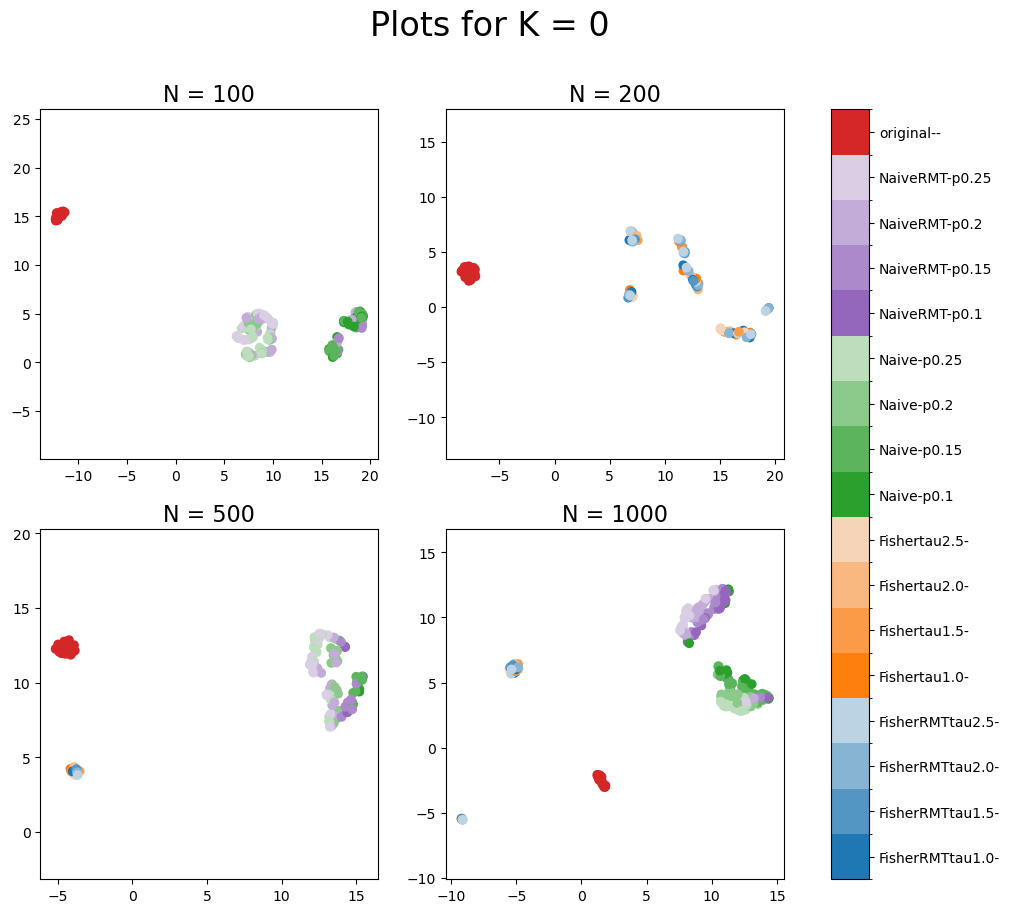

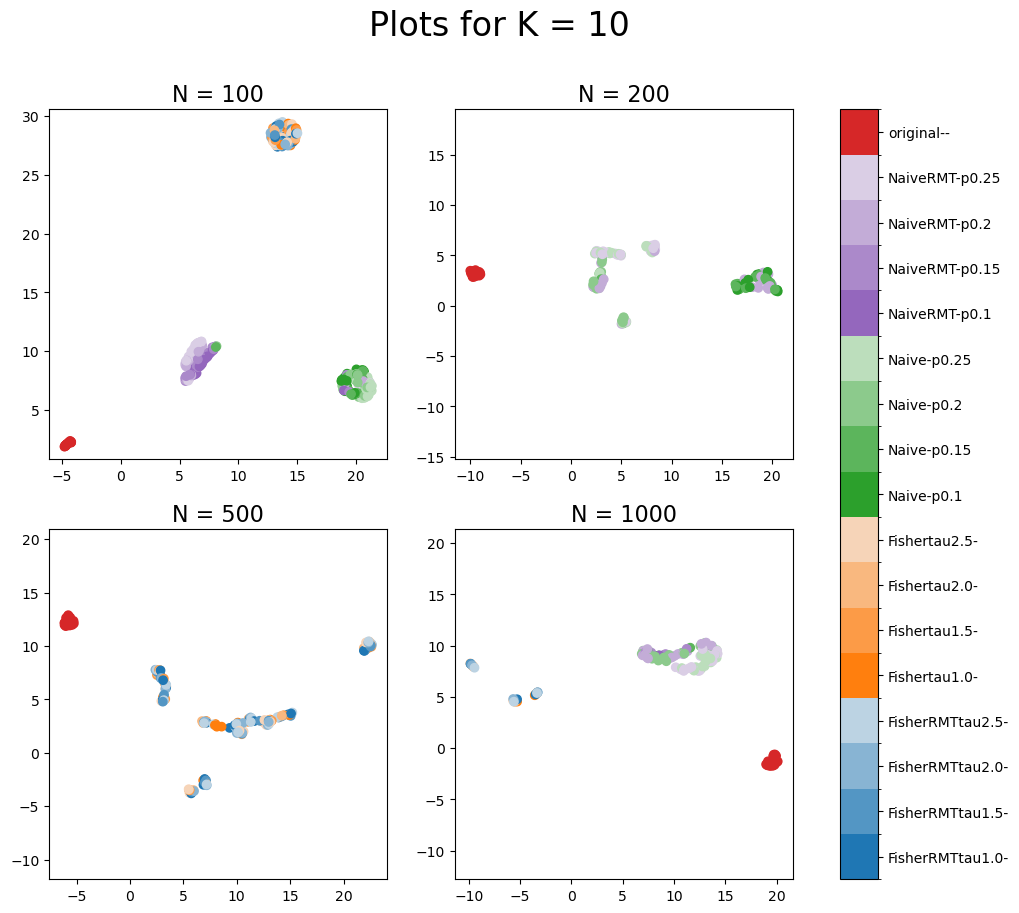

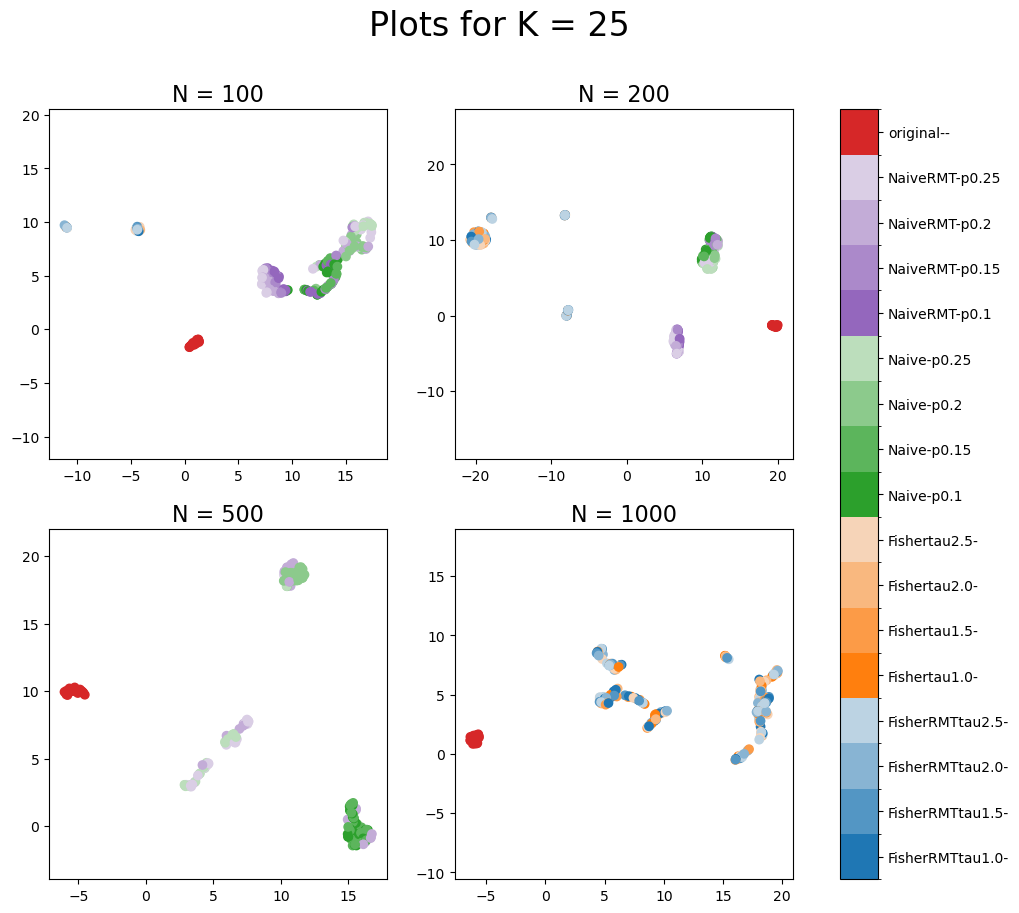

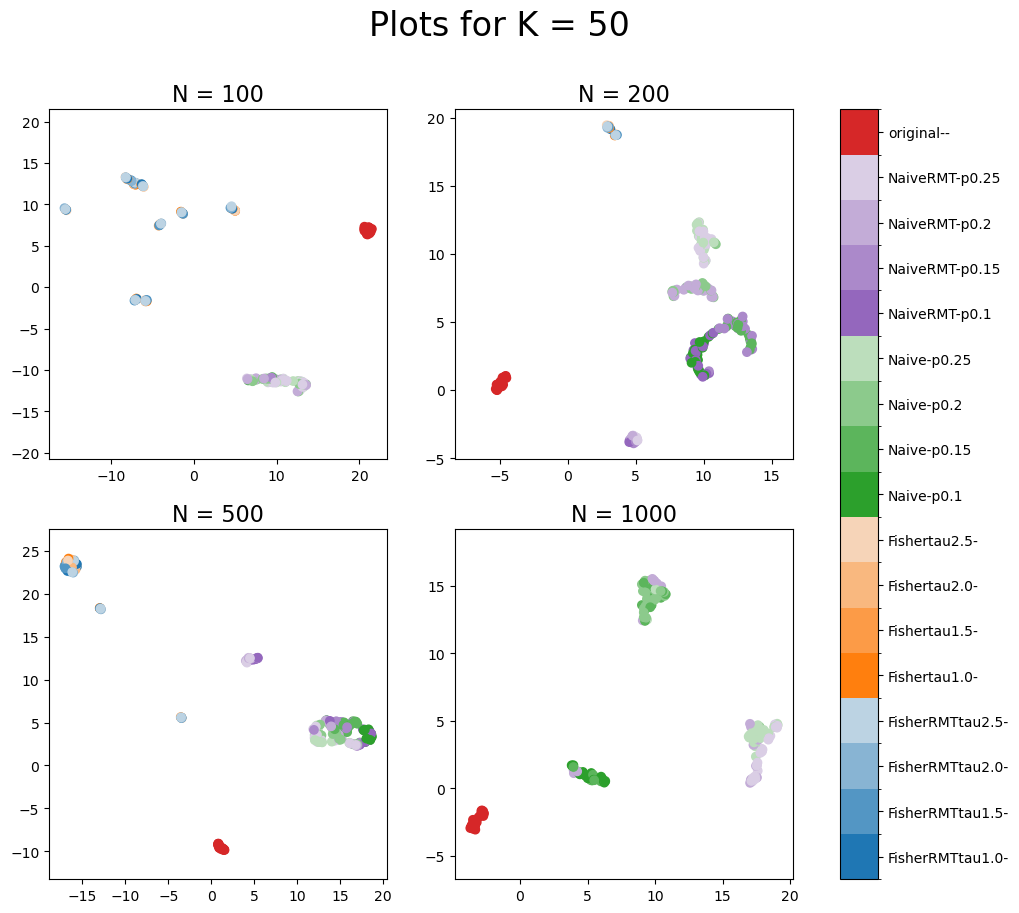

In [20]:
n_plots = len(embeddings)
palette = create_palette()

# Create a colormap from the custom palette
cmap = mcolors.ListedColormap(palette)

# Normalize feature values for color mapping
features = np.unique(df100["type"].values)
norm = mcolors.BoundaryNorm(boundaries=np.arange(len(features) + 1), ncolors=len(features))

N_list = [100, 200, 500, 1000]

emb_num = 0
values = [0, 10, 25, 50]
for val in values:
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle(f'Plots for K = {val}', fontsize=24)
    
    for i, ax in enumerate(axs.flat):
        embedding = embeddings[emb_num]
        
        # Scatter plot for each subplot
        scatter = ax.scatter(
            embedding[:, 0],
            embedding[:, 1],
            c=numeric_labels_list[emb_num],  # Use numeric labels for color mapping
            cmap=cmap,
            norm=norm
        )
        ax.set_aspect('equal', 'datalim')
        ax.set_title(f'N = {N_list[i]}', fontsize=16)

        emb_num += 1
    
    # Add a single colorbar for each figure
    fig.colorbar(scatter, ax=axs, orientation='vertical', ticks=np.arange(len(features)) + 0.5).ax.set_yticklabels(features)
    
    # plt.tight_layout()  # Adjust layout to fit title
    plt.show()